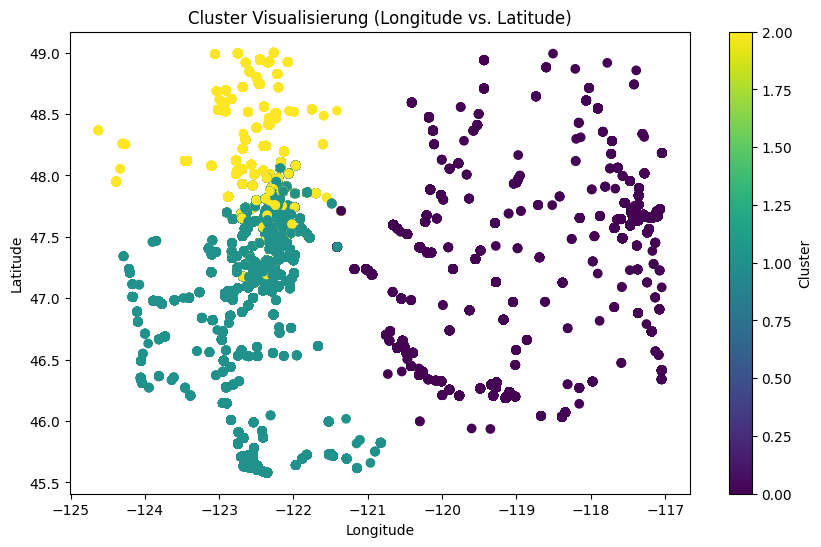

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import Birch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

df = pd.read_parquet('../data/Electric_Vehicle_Population_Data_cleaned.parquet')
df.head()


selected_features = ["longitude", "latitude", "Make", "Vehicle_Age"]
df_features = df[selected_features]

# One-Hot-Encoding der kategorialen Features
df_categorical = pd.get_dummies(df_features[[ "Make"]])

# Numerische Features
df_numeric = df_features[["longitude", "latitude"]]

# Numerische Features skalieren
scaler = StandardScaler()
df_numeric_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

# Zusammenführen der skalierten numerischen und kodierten kategorialen Features
X = np.hstack([df_numeric_scaled.values, df_categorical.values])

# Birch Clustering durchführen
birch_model = Birch(n_clusters=3, branching_factor=100, threshold=0.2)
birch_model.fit(X)

# Cluster-Zuweisungen zum DataFrame hinzufügen
df['cluster'] = birch_model.labels_

# Scatterplot der Cluster basierend auf longitude und latitude
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['longitude'], df['latitude'], c=df['cluster'], cmap='viridis')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Cluster Visualisierung (Longitude vs. Latitude)")
plt.colorbar(scatter, label='Cluster')
plt.show()

/var/folders/t5/mxgw5t8j2236t033_3djvdgh0000gn/T/ipykernel_49608/3165842396.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('Blues' if i==0 else 'Reds' if i==1 else 'Greens')
/var/folders/t5/mxgw5t8j2236t033_3djvdgh0000gn/T/ipykernel_49608/3165842396.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('Blues' if i==0 else 'Reds' if i==1 else 'Greens')
/var/folders/t5/mxgw5t8j2236t033_3djvdgh0000gn/T/ipykernel_49608/3165842396.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colo

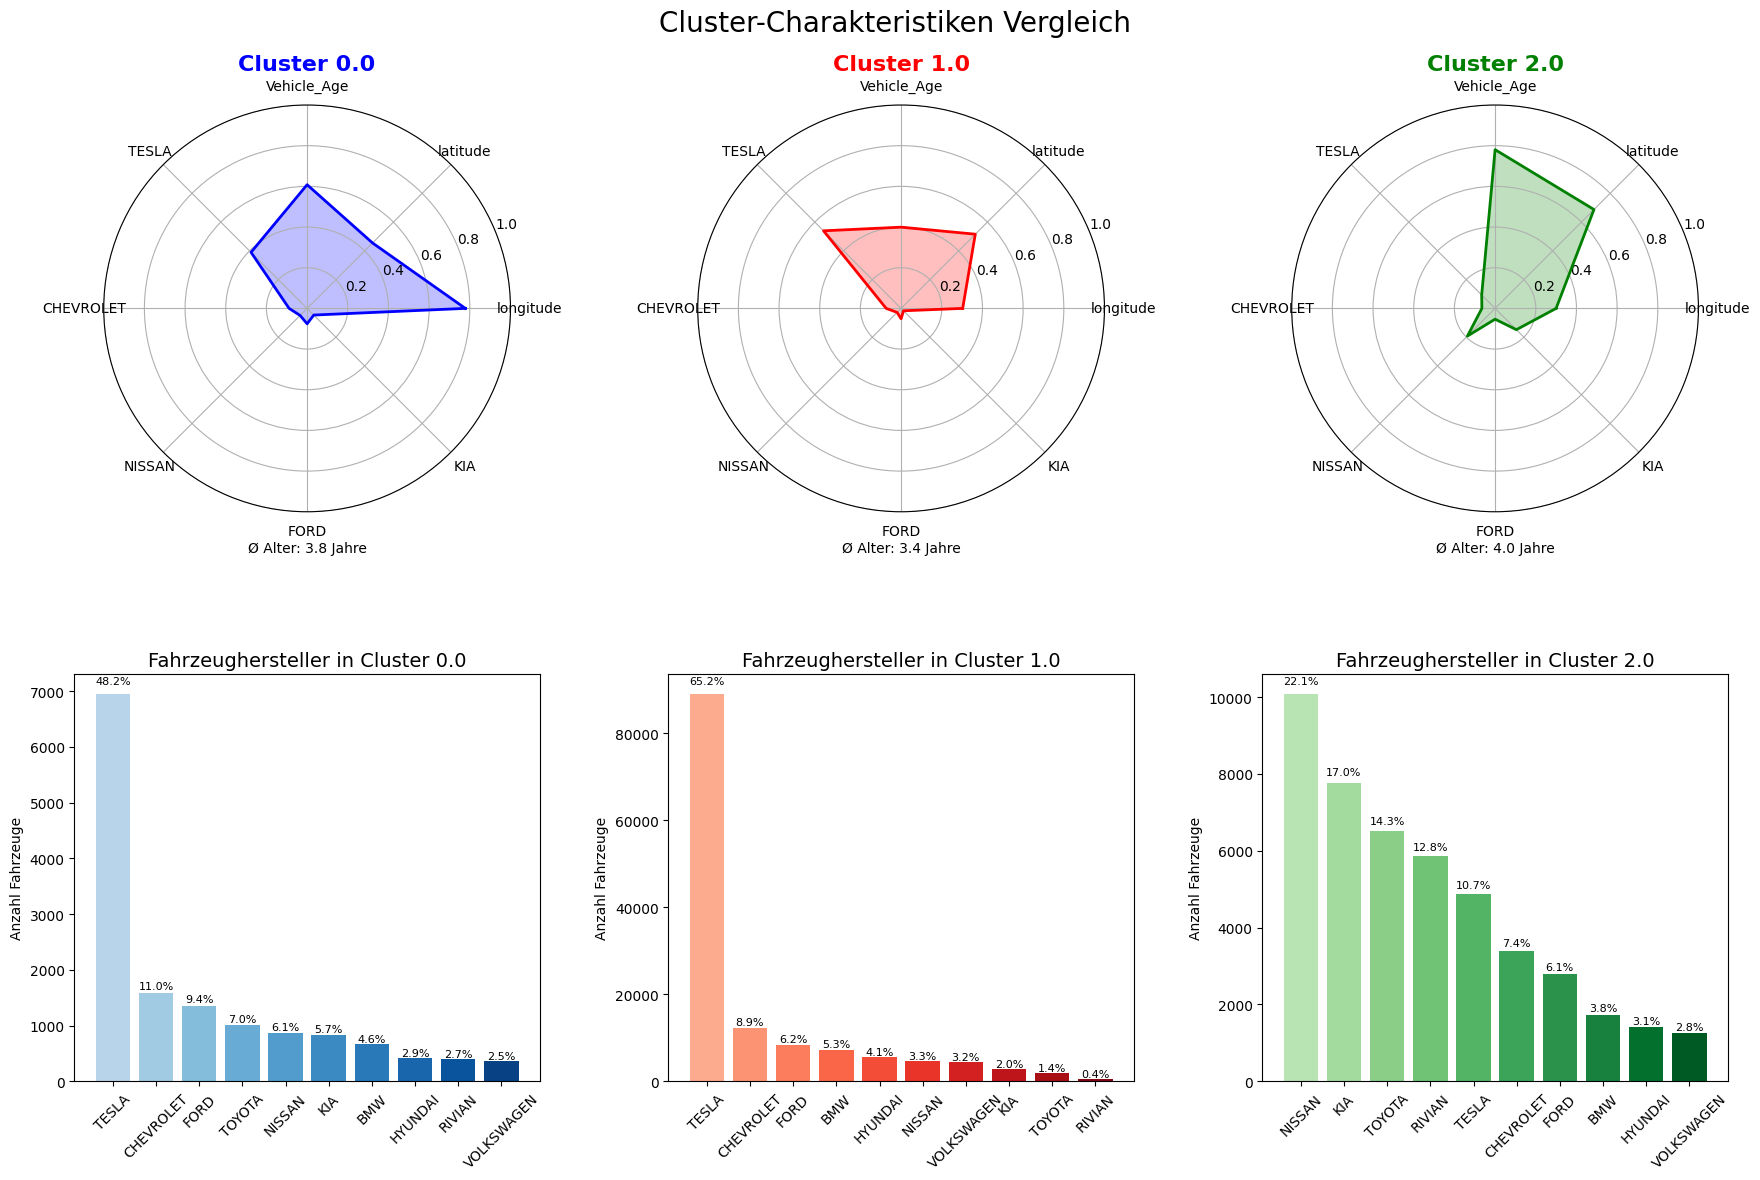

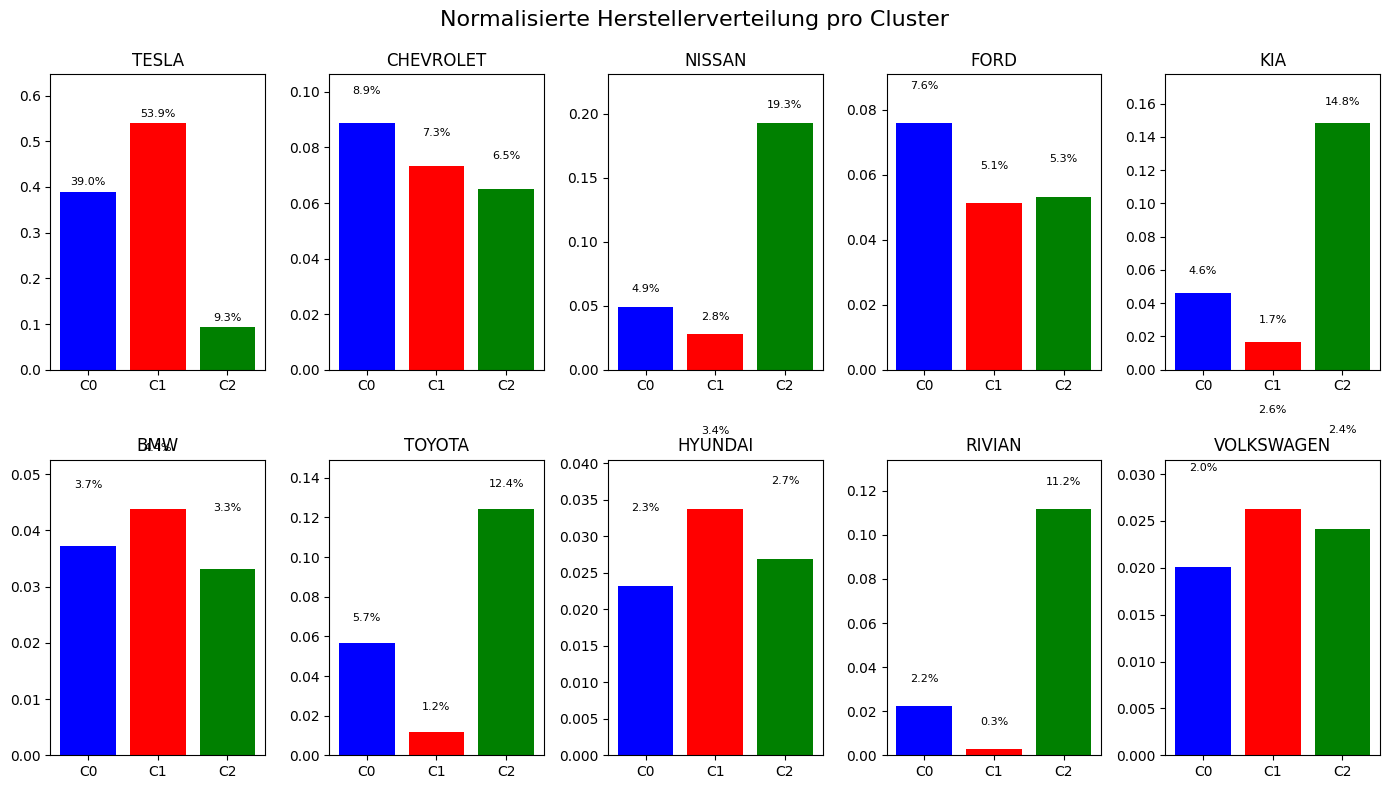

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Vorbereitung der Daten
cluster_features = df[["longitude", "latitude", "Vehicle_Age"]]
make_clusters = pd.crosstab(df['cluster'], df['Make'])
make_clusters_pct = make_clusters.div(make_clusters.sum(axis=1), axis=0)

top_makes = make_clusters.sum().nlargest(10).index.tolist()
make_clusters_top = make_clusters[top_makes]
make_clusters_pct_top = make_clusters_pct[top_makes]

cluster_stats = df.groupby('cluster').agg({
    'longitude': 'mean',
    'latitude': 'mean',
    'Vehicle_Age': 'mean'
}).reset_index()

# Normalisierung für bessere Visualisierung
numeric_cols = ["longitude", "latitude", "Vehicle_Age"]
cluster_stats_norm = cluster_stats.copy()

for col in numeric_cols[:2]:  # Nur Längen- und Breitengrad normal normalisieren
    min_val = df[col].min()
    max_val = df[col].max()
    cluster_stats_norm[col] = (cluster_stats[col] - min_val) / (max_val - min_val)

# Fahrzeugalter verstärkt normalisieren
min_age = df["Vehicle_Age"].min()
max_age = df["Vehicle_Age"].max()
mean_age = df["Vehicle_Age"].mean()
std_age = df["Vehicle_Age"].std()

# Verstärkte Skalierung: Werte um Mittelwert werden mehr gespreizt
cluster_stats_norm["Vehicle_Age"] = (cluster_stats["Vehicle_Age"] - mean_age) / (std_age * 0.5) + 0.5
cluster_stats_norm["Vehicle_Age"] = np.clip(cluster_stats_norm["Vehicle_Age"], 0, 1)  # Auf [0,1] begrenzen

# Ein Array für jede Cluster-Eigenschaft erstellen
feature_names = numeric_cols + top_makes[:5]  # Top 5 für Radar-Diagramm
n_features = len(feature_names)

# Winkel für das Radar-Diagramm berechnen
angles = np.linspace(0, 2*np.pi, len(feature_names), endpoint=False).tolist()
angles += angles[:1]  # Schließen des Kreises

# Erstellen der Figur: Radar-Diagramme oben, Balkendiagramme unten
fig = plt.figure(figsize=(18, 12))
plt.suptitle('Cluster-Charakteristiken Vergleich', size=20, y=0.98)

# Farben für die Cluster
colors = ['blue', 'red', 'green']

# Erstelle Radar-Diagramme (obere Zeile)
for i in range(3):
    cluster_id = cluster_stats.iloc[i]['cluster']
    
    # Radar-Diagramm in der oberen Zeile
    ax_radar = fig.add_subplot(2, 3, i+1, polar=True)
    
    # Daten für den aktuellen Cluster
    numeric_values = cluster_stats_norm.iloc[i][numeric_cols].values.tolist()
    make_values = make_clusters_pct.loc[cluster_id, top_makes[:5]].values.tolist()
    values = numeric_values + make_values
    values += values[:1]  # Schließen des Kreises
    
    # Zeichnen des Radar-Diagramms
    ax_radar.plot(angles, values, color=colors[i], linewidth=2)
    ax_radar.fill(angles, values, color=colors[i], alpha=0.25)
    
    # Achsenbeschriftungen hinzufügen
    ax_radar.set_xticks(angles[:-1])
    ax_radar.set_xticklabels(feature_names)
    
    # Kreise für die Skala
    ax_radar.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax_radar.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])
    ax_radar.set_rlim(0, 1)
    
    # Titel für jedes Diagramm
    ax_radar.set_title(f'Cluster {cluster_id}', size=16, color=colors[i], fontweight='bold')

    # Balkendiagramm in der unteren Zeile für die Top 10 Hersteller
    ax_bar = fig.add_subplot(2, 3, i+4)
    
    # Hersteller-Anteile für aktuellen Cluster
    make_data = make_clusters_top.loc[cluster_id]
    total_vehicles = make_data.sum()
    
    # Balken sortieren und zeichnen
    sorted_indices = make_data.sort_values(ascending=False).index
    sorted_makes = sorted_indices.tolist()
    sorted_values = make_data[sorted_indices].tolist()
    
    # Balkenfarben erstellen: Hauptfarbe mit verschiedenen Alpha-Werten
    alpha_values = np.linspace(0.9, 0.3, len(sorted_makes))
    bar_colors = []
    
    # Für jeden Hersteller eine Farbe mit entsprechendem Alpha-Wert erstellen
    for alpha in alpha_values:
        # RGB-Farbe mit Alpha-Wert kombinieren
        rgba_color = list(plt.matplotlib.colors.to_rgba(colors[i]))
        rgba_color[3] = alpha  # Alpha-Wert setzen
        bar_colors.append(rgba_color)
    
    # Balkendiagramm mit den vorbereiteten Farben zeichnen
    bars = ax_bar.bar(sorted_makes, sorted_values, color=bar_colors)
    
    # Prozentsatz über jedem Balken anzeigen
    for j, bar in enumerate(bars):
        height = bar.get_height()
        pct = height / total_vehicles * 100
        ax_bar.text(bar.get_x() + bar.get_width()/2., height + 5,
                 f'{pct:.1f}%', ha='center', va='bottom', fontsize=8)
    
    ax_bar.set_title(f'Fahrzeughersteller in Cluster {cluster_id}', size=14)
    ax_bar.set_ylabel('Anzahl Fahrzeuge')
    ax_bar.tick_params(axis='x', rotation=45)
    
    # Add grid lines
    ax_radar.grid(True, linestyle='-', alpha=0.7)
    
    # Hinweis zum Durchschnittsalter
    ax_radar.annotate(f'Ø Alter: {cluster_stats.iloc[i]["Vehicle_Age"]:.1f} Jahre', 
                     xy=(0.5, -0.1), xycoords='axes fraction', ha='center')

plt.tight_layout()
plt.subplots_adjust(top=0.9, hspace=0.4)
plt.show()

# Zusätzlich einen normierten Plot erstellen, um die Verteilung der Hersteller zu vergleichen
plt.figure(figsize=(14, 8))
plt.suptitle('Normalisierte Herstellerverteilung pro Cluster', size=16)

# Farbskala für die Cluster
cluster_colors = ['blue', 'red', 'green']

# Für jeden Hersteller die normalisierte Verteilung über Cluster hinweg zeigen
for i, make in enumerate(top_makes):
    plt.subplot(2, 5, i+1)
    
    # Daten normalisieren innerhalb jedes Herstellers
    make_norm = make_clusters_pct[make].values
    
    # Balken zeichnen
    bars = plt.bar([f'Cluster {i}' for i in range(3)], make_norm, color=cluster_colors)
    
    # Prozentwerte anzeigen
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height*100:.1f}%', ha='center', va='bottom', fontsize=8)
    
    plt.title(make)
    plt.ylim(0, max(make_norm) * 1.2)  # Platz für Beschriftungen
    
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()